## Advantage actor-critic in AgentNet (5 pts)

Once we're done with REINFORCE, it's time to proceed with something more sophisticated.
The next one in line is advantage actor-critic, in which agent learns both policy and value function, using the latter to speed up learning.

Your main objective for this session is to... beat MountainCar-v0... with actor-critic.

Beating means making submission to [gym leaderboard](https://gym.openai.com/envs/MountainCar-v0).

``` MountainCar-v0 defines "solving" as getting average reward of -110.0 over 100 consecutive trials. ```


In [1]:
%env THEANO_FLAGS='floatX=float32'
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1
        
import numpy as np
import matplotlib.pyplot as plt
import theano
from theano import tensor as T
%matplotlib inline

env: THEANO_FLAGS='floatX=float32'
Starting virtual X frame buffer: Xvfb.
env: DISPLAY=:1


In [2]:
import gym
from gym.wrappers import TimeLimit

env = gym.make("MountainCar-v0")
obs = env.reset()
state_size = len(obs)
n_actions = env.action_space.n
print(obs)

[2017-10-02 14:26:31,946] Making new env: MountainCar-v0


[-0.50811701  0.        ]


# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using shallow neural network.


In [3]:
import lasagne
from lasagne.nonlinearities import elu, softmax, rectify
from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer, batch_norm, dropout
#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,state_size))
layer = DenseLayer(observation_layer, num_units=256, nonlinearity=rectify)
layer = DenseLayer(layer, num_units=128, nonlinearity=rectify)

In [4]:
#a layer that predicts Qvalues
policy_layer = DenseLayer(layer, num_units=n_actions, nonlinearity=softmax)

V_layer = DenseLayer(layer, num_units=1, nonlinearity=None)

In [5]:
eps = theano.shared(np.float32(0.0), allow_downcast=True)
policy_smooth_layer = NonlinearityLayer(policy_layer,
                                        lambda p: (1. - eps) * p + eps / n_actions)

#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import ProbabilisticResolver
action_layer = ProbabilisticResolver(policy_smooth_layer,
                                     name="e-greedy action picker",
                                     assume_normalized=True)

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [6]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(policy_layer, V_layer),
              action_layers=action_layer)

In [7]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params((action_layer, V_layer), trainable=True)
weights

[W, b, W, b, W, b, W, b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [8]:
from agentnet.experiments.openai_gym.pool import EnvPool

#create a small pool with 10 parallel agents
pool = EnvPool(agent,"MountainCar-v0", n_games=64, max_size=13000) 

#we assume that pool size 1000 is small enough to learn "almost on policy" :)

[2017-10-02 14:26:32,469] Making new env: MountainCar-v0
[2017-10-02 14:26:32,473] Making new env: MountainCar-v0
[2017-10-02 14:26:32,476] Making new env: MountainCar-v0
[2017-10-02 14:26:32,480] Making new env: MountainCar-v0
[2017-10-02 14:26:32,483] Making new env: MountainCar-v0
[2017-10-02 14:26:32,487] Making new env: MountainCar-v0
[2017-10-02 14:26:32,490] Making new env: MountainCar-v0
[2017-10-02 14:26:32,493] Making new env: MountainCar-v0
[2017-10-02 14:26:32,496] Making new env: MountainCar-v0
[2017-10-02 14:26:32,498] Making new env: MountainCar-v0
[2017-10-02 14:26:32,501] Making new env: MountainCar-v0
[2017-10-02 14:26:32,503] Making new env: MountainCar-v0
[2017-10-02 14:26:32,504] Making new env: MountainCar-v0
[2017-10-02 14:26:32,506] Making new env: MountainCar-v0
[2017-10-02 14:26:32,507] Making new env: MountainCar-v0
[2017-10-02 14:26:32,509] Making new env: MountainCar-v0
[2017-10-02 14:26:32,510] Making new env: MountainCar-v0
[2017-10-02 14:26:32,511] Makin

In [9]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_log[:3])
print(reward_log[:3])

[[2 2 1 1 2 0 0]
 [0 0 2 2 2 1 1]
 [0 2 1 1 2 0 0]]
[[-1. -1. -1. -1. -1. -1.  0.]
 [-1. -1. -1. -1. -1. -1.  0.]
 [-1. -1. -1. -1. -1. -1.  0.]]
CPU times: user 20 ms, sys: 10 ms, total: 30 ms
Wall time: 16.7 ms


In [10]:
SEQ_LENGTH = 10
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Actor-critic loss

Here we define obective function for actor-critic (one-step) RL.

* We regularize policy with expected inverse action probabilities (discouraging very small probas) to make objective numerically stable


In [11]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(128, replace=True)

_,_,_,_,(policy_seq, V_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)

In [12]:
from agentnet.learning import a2c                                                   

elwise_mse_loss = a2c.get_elementwise_objective(policy_seq,
                                                V_seq[:,:,0],
                                                replay.actions[0],
                                                replay.rewards,
                                                replay.is_alive,
                                                gamma_or_gammas=0.99,
                                                n_steps=1)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

loss += 0.01 * (1. / policy_seq).mean()

In [13]:
from theano import tensor as T

neg_H = (policy_seq * T.log(policy_seq)).sum(axis=-1).mean()
#loss += neg_H * 0.01

In [14]:
# Compute weight updates
updates = lasagne.updates.rmsprop(loss,weights,learning_rate=0.001)

In [15]:
import theano
train_step = theano.function([],[loss, -neg_H],updates=updates)

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
[2017-10-02 14:26:55,877] We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


# Training loop


In [16]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {}

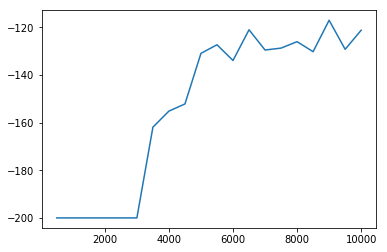

100%|██████████| 10000/10000 [43:08<00:00,  2.24it/s]


In [17]:
from tqdm import tqdm
from IPython.display import clear_output

#the loop may take eons to finish.
#consider interrupting early.
loss = 0
entropy = 0
eps_val = 1.0
for i in tqdm(range(10000)):    
    eps_val *= 0.998
    eps.set_value(eps_val)
    
    for _ in range(10):
        pool.update(SEQ_LENGTH, append=True)
    
    for _ in range(10):
        l, h = train_step()
        loss = loss*0.99 + l*0.01
        entropy = entropy * 0.99 + h * 0.01
    
    
    if epoch_counter%100==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = np.average(pool.experience_replay.rewards.get_value()[:,:-1],
                                      weights=1+pool.experience_replay.is_alive.get_value()[:,:-1])
        print("iter=%i\treward/step=%.5f\tloss ma=%.5f\tentropy ma=%.5f"%(epoch_counter,
                                                        pool_mean_reward,
                                                        loss, entropy))
        

    ##record current learning progress and show learning curves
    if epoch_counter%500 ==0:
        n_games = 20
        eps.set_value(0)
        rewards[epoch_counter] = np.mean(pool.evaluate( record_video=False,n_games=n_games,
                                               verbose=False))
        print("Current score(mean over %i) = %.3f"%(n_games,np.mean(rewards[epoch_counter])))
        clear_output(True)
        plt.plot(*zip(*sorted(rewards.items(),key=lambda t: t[0])))
        plt.show()
    
    epoch_counter += 1

    
# Time to drink some coffee!

In [18]:
iters,session_rewards=zip(*sorted(rewards.items(),key=lambda k: k[0]))

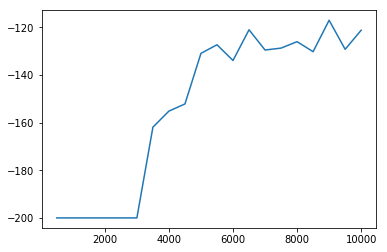

In [19]:
plt.plot(iters,list(map(np.mean,session_rewards)))

### Visualizing the $V(s)$ and  $\pi(a|s)$

Since the observation space is just 2-dimensional, we can plot it on a 2d scatter-plot to gain insight of what agent learned.

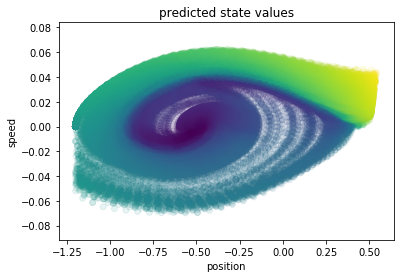

In [20]:
_,_,_,_,(pool_policy,pool_V) = agent.get_sessions(
    pool.experience_replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,)

plt.scatter(
    *pool.experience_replay.observations[0].get_value().reshape([-1,2]).T,
    c = pool_V.ravel().eval(),
    alpha = 0.1)
plt.title("predicted state values")
plt.xlabel("position")
plt.ylabel("speed")

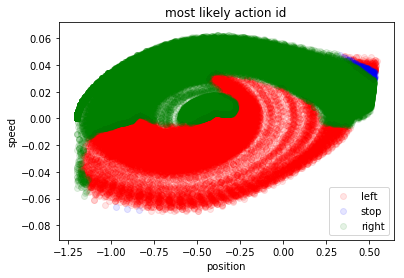

In [21]:
obs_x,obs_y = pool.experience_replay.observations[0].get_value().reshape([-1,2]).T
optimal_actid = pool_policy.argmax(-1).ravel().eval()
action_names=["left","stop","right"]
for i in range(3):
    sel = optimal_actid==i
    plt.scatter(obs_x[sel],obs_y[sel],
                c=['red','blue','green'][i],
                alpha = 0.1,label=action_names[i])
    
plt.title("most likely action id")
plt.xlabel("position")
plt.ylabel("speed")
plt.legend(loc='best')

### Variations in the algorithm (2 pts)

Try different `n_steps` param to see if it improves learning performance.

Your objective is to compare learning curves for 1, 3, 10 and 25-step updates (or any grid you think is appropriate).

For 25-step updates, please also increase SEQ_LENGTH to 25.

Also evaluate how performance changes with different entropy regularizer coefficient.

_bonus_ See if you can learn effectively without experience replay (may need a lot of parallel agents)

In [22]:
#<a lot of your code here>

### Bonus section (5+ pts)

Beat the [`LunarLanderContinuous-v2`](https://gym.openai.com/envs/LunarLanderContinuous-v2) with continuous version of advantage actor-critic.

You will require a multidimensional gaussian (or similar) policy from your agent.

You can implement that by feeding a2c.get_elementwise_objective probabilities of agent's chosen actions (it will be 2-dimensional) instead of all actions.

Contact us if you have any questions.

### 